# Railway Feature Extraction Setup

This notebook sets up the data processing pipeline for loading high-resolution drone orthophotos and railway shapefiles. It performs CRS consistency checks and visualizes the railway vectors over the orthophoto.

In [2]:
import os
import rasterio
from rasterio.features import rasterize
from rasterio.windows import Window
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box

# Configure plot size
plt.rcParams['figure.figsize'] = (12, 12)

In [3]:
# Paths to data
IMAGE_PATH = "../data/images/28996_NADALA_ORTHO.tif"
SHP_PATH = "../data/shp/Railway.shp"

print(f"Image Path: {IMAGE_PATH}")
print(f"Shapefile Path: {SHP_PATH}")

Image Path: ../data/images/28996_NADALA_ORTHO.tif
Shapefile Path: ../data/shp/Railway.shp


In [4]:
# 1. Load Orthophoto Metadata
with rasterio.open(IMAGE_PATH) as src:
    ortho_meta = src.meta.copy()
    ortho_crs = src.crs
    ortho_transform = src.transform
    ortho_shape = src.shape
    ortho_bounds = src.bounds
    
    print(f"Orthophoto CRS: {ortho_crs}")
    print(f"Orthophoto Shape: {ortho_shape}")
    print(f"Orthophoto Bounds: {ortho_bounds}")

Orthophoto CRS: EPSG:32643
Orthophoto Shape: (27390, 26259)
Orthophoto Bounds: BoundingBox(left=540378.3252300001, bottom=3489958.00821, right=541176.59883, top=3490790.66421)


In [5]:
# 2. Load and Reproject Shapefile
gdf = gpd.read_file(SHP_PATH)
print(f"Original Shapefile CRS: {gdf.crs}")

# Ensure CRS consistency
if gdf.crs != ortho_crs:
    print(f"Reprojecting shapefile from {gdf.crs} to {ortho_crs}...")
    gdf = gdf.to_crs(ortho_crs)
    print("Reprojection complete.")
else:
    print("CRS matches, no reprojection needed.")

# Display first few rows
print(gdf.head())

# Check intersection with orthophoto bounds
ortho_box = box(ortho_bounds.left, ortho_bounds.bottom, ortho_bounds.right, ortho_bounds.top)
railways_in_image = gdf[gdf.geometry.intersects(ortho_box)]
print(f"Number of railway features within orthophoto bounds: {len(railways_in_image)}")

Original Shapefile CRS: EPSG:3857
Reprojecting shapefile from EPSG:3857 to EPSG:32643...
Reprojection complete.
   OBJECTID GlobalID Uniq_Id State_Code District_C Tehsil_Cod Block_Code  \
0         0     None    None         03         33        215        274   
1         0     None    None         03         33        215        274   
2         0     None    None         03         33        215        274   
3         0     None    None         03         33        215        274   

  Village_Co LGD_Code    Village_Na  Railway_Ty  Name  Width Electrfd  \
0      31220    31220  harse mansar           2  None    0.0     None   
1      31220    31220  harse mansar           2  None    0.0     None   
2      31220    31220  harse mansar           2  None    0.0     None   
3      31220    31220  harse mansar           2  None    0.0     None   

  Property_I Remarks Adl_Info  SHAPE_Leng  \
0       None    None     None  561.664701   
1       None    None     None  561.454871   
2     

In [6]:
# 3. Windowed Rasterization and Visualization Function
def visualize_window(image_path, gdf, window_slice, title="Alignment Check"):
    """
    Reads a window from the large image, rasterizes the vector mask for that window, and plots them.
    window_slice: Window(col_off, row_off, width, height)
    """
    with rasterio.open(image_path) as src:
        # Read the image data in the window
        img_data = src.read(window=window_slice)
        
        # Calculate the transform for this specific window
        window_transform = src.window_transform(window_slice)
        
        # Get the spatial bounds of the window to filter vectors
        bounds = rasterio.windows.bounds(window_slice, src.transform)
        
        # Filter visible vectors using spatial index
        # Use cx (coordinate index) for faster lookup
        visible_features = gdf.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        
        if visible_features.empty:
            print("No railways found in this window.")
            mask = np.zeros((window_slice.height, window_slice.width), dtype='uint8')
        else:
            # Rasterize relevant features
            shapes = ((geom, 1) for geom in visible_features.geometry)
            mask = rasterize(
                shapes,
                out_shape=(window_slice.height, window_slice.width),
                transform=window_transform,
                fill=0,
                default_value=1,
                dtype='uint8',
                all_touched=True  # Important for lines/railways to ensure they are captured
            )
            
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    
    # Prepare RGB image for display
    if img_data.shape[0] >= 3:
        rgb_img = np.transpose(img_data[:3, :, :], (1, 2, 0))
    else:
        rgb_img = img_data[0, :, :]
        
    # Normalize if necessary (simple min-max for display)
    if rgb_img.dtype != np.uint8:
        rgb_img = ((rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min()) * 255).astype(np.uint8)

    ax[0].imshow(rgb_img)
    ax[0].set_title("Orthophoto Window")
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray', interpolation='nearest')
    ax[1].set_title("Rasterized Mask")
    ax[1].axis('off')
    
    # Overlay
    ax[2].imshow(rgb_img)
    ax[2].imshow(mask, alpha=0.5, cmap='spring')  # Overlay mask with transparency
    ax[2].set_title("Overlay")
    ax[2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [7]:
# 4. Select a Window and Visualize
# Find a feature to center upon
if not railways_in_image.empty:
    # Get the bounding box of the first railway feature
    feature_bounds = railways_in_image.iloc[0].geometry.bounds
    center_x = (feature_bounds[0] + feature_bounds[2]) / 2
    center_y = (feature_bounds[1] + feature_bounds[3]) / 2
    
    with rasterio.open(IMAGE_PATH) as src:
        # Convert map coordinates to pixel coordinates
        row, col = src.index(center_x, center_y)
        
        # Define window size
        w_width, w_height = 2000, 2000
        
        # Calculate window offset
        col_off = max(0, col - w_width // 2)
        row_off = max(0, row - w_height // 2)
        
        # Ensure window doesn't go out of bounds
        col_off = min(col_off, src.width - w_width)
        row_off = min(row_off, src.height - w_height)
        
        # Create Window object
        window = Window(col_off, row_off, w_width, w_height)
        
        print(f"Displaying window: {window} around center ({center_x}, {center_y})")
        visualize_window(IMAGE_PATH, gdf, window)
else:
    print("No railway features found in the orthophoto bounds to visualize.")

No railway features found in the orthophoto bounds to visualize.


In [8]:
import os
import glob
import rasterio
import geopandas as gpd
from shapely.geometry import box

# directory containing your images
IMAGE_DIR = "../data/images"
SHP_PATH = "../data/shp/Railway.shp"

# Load shapefile
gdf = gpd.read_file(SHP_PATH)
print("Shapefile loaded. CRS:", gdf.crs)

found_image = None
# Initialize empty gdf with matching CRS and geometry column structure
railways_in_image = gpd.GeoDataFrame(columns=gdf.columns, crs=gdf.crs, geometry='geometry')

# Iterate over all TIF files to find one with railways
tif_files = glob.glob(os.path.join(IMAGE_DIR, "*.tif"))
print(f"Checking {len(tif_files)} images for railway intersection...")

for img_path in tif_files:
    with rasterio.open(img_path) as src:
        # Reproject shapefile if needed
        if gdf.crs != src.crs:
            gdf_proj = gdf.to_crs(src.crs)
        else:
            gdf_proj = gdf
            
        # Create bounding box for the image
        img_box = box(src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top)
        
        # Check intersection
        intersecting = gdf_proj[gdf_proj.geometry.intersects(img_box)]
        
        if not intersecting.empty:
            print(f"Found match! Image: {os.path.basename(img_path)} has {len(intersecting)} railway segments.")
            found_image = img_path
            railways_in_image = intersecting
            IMAGE_PATH = img_path  # Update the main IMAGE_PATH variable
            break

if found_image:
    print(f"\nUsing Image: {found_image}")
else:
    print("\nWARNING: No images found with intersecting railways. Visualization will be empty.")
    # Fallback to the original if nothing found, just to keep code running
    IMAGE_PATH = "../data/images/28996_NADALA_ORTHO.tif"

Shapefile loaded. CRS: EPSG:3857
Checking 3 images for railway intersection...



In [9]:
import numpy as np
import cv2
from rasterio.features import rasterize

def generate_save_mask(image_path, gdf_segments, output_dir="../data/masks", buffer_size=2):
    """
    Rasterizes vector segments into a binary mask matching the image.
    buffer_size: Buffer in meters (or map units) to create width for the tracks.
    """
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.basename(image_path).replace(".tif", "")
    
    with rasterio.open(image_path) as src:
        meta = src.meta.copy()
        transform = src.transform
        shape = src.shape
        
        # Buffer the line geometries to create a polygon (thickness)
        # Check if gdf has geometries
        if gdf_segments.empty:
             buffered_shapes = []
        else:
             buffered_shapes = [(geom.buffer(buffer_size), 1) for geom in gdf_segments.geometry]
        
        if not buffered_shapes:
            print("No shapes to rasterize. Creating empty mask.")
            mask = np.zeros(shape, dtype=np.uint8)
        else:
            # Rasterize
            mask = rasterize(
                buffered_shapes,
                out_shape=shape,
                transform=transform,
                fill=0,
                default_value=1,
                dtype=rasterio.uint8
            )
            
    # Save as PNG (0-255 for visualization tools)
    mask_png_path = os.path.join(output_dir, f"{filename}_mask.png")
    cv2.imwrite(mask_png_path, mask * 255)
    
    # Save as NPY (binary 0/1 for ML)
    mask_npy_path = os.path.join(output_dir, f"{filename}_mask.npy")
    np.save(mask_npy_path, mask)
    
    print(f"Saved Binary Mask: {mask_png_path}")
    print(f"Saved Numpy Array: {mask_npy_path}")
    
    return mask

# Run generation
# Ensure railways_in_image corresponds to the selected IMAGE_PATH's CRS
with rasterio.open(IMAGE_PATH) as src:
    # Only reproject if we actually have data
    if not railways_in_image.empty and railways_in_image.crs != src.crs:
        railways_in_image = railways_in_image.to_crs(src.crs)

full_mask = generate_save_mask(IMAGE_PATH, railways_in_image)

No shapes to rasterize. Creating empty mask.
Saved Binary Mask: ../data/masks/28996_NADALA_ORTHO_mask.png
Saved Numpy Array: ../data/masks/28996_NADALA_ORTHO_mask.npy


In [10]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Check for CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# 1. Model Definition: UNet with ResNet34 backbone
# ResNet34 is a great balance between speed and accuracy for simple linear features like railways.
model = smp.Unet(
    encoder_name="resnet34",        # Encoder: ResNet34
    encoder_weights="imagenet",     # Pretrained weights for faster convergence
    in_channels=3,                  # Input: RGB
    classes=1,                      # Output: Binary Mask (Railway or Background)
    activation=None                 # We will apply Sigmoid in the loss/inference manually
)

model.to(DEVICE)
print("\nModel initialized: UNet (ResNet34) -> Binary Output")

# 2. Loss Function: BCE + Dice
# Useful for class imbalance (railways are very sparse compared to the background)
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.bce_weight = bce_weight

    def forward(self, pred, target):
        loss_bce = self.bce(pred, target)
        loss_dice = self.dice(pred, target)
        return (self.bce_weight * loss_bce) + ((1 - self.bce_weight) * loss_dice)

loss_fn = BCEDiceLoss(bce_weight=0.5)
print("Loss Function: BCE + Dice Loss")

# 3. Metrics: IoU and Pixel Accuracy
def calculate_metrics(pred_logits, target_mask, threshold=0.5):
    """
    Computes Intersection over Union (IoU) and Pixel Accuracy.
    """
    # Apply Sigmoid and Threshold
    pred_mask = (torch.sigmoid(pred_logits) > threshold).float()
    
    # Flatten
    pred_flat = pred_mask.view(-1)
    target_flat = target_mask.view(-1)
    
    # Accuracy
    correct = (pred_flat == target_flat).sum().item()
    total = target_flat.numel()
    pixel_acc = correct / total
    
    # IoU
    intersection = (pred_flat * target_flat).sum().item()
    union = pred_flat.sum().item() + target_flat.sum().item() - intersection
    
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
    else:
        iou = intersection / union
        
    return iou, pixel_acc

print("Metrics defined: IoU, Pixel Accuracy")

/home/anushtup-ghosh/Documents/Projects/natgeo/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

Model initialized: UNet (ResNet34) -> Binary Output
Loss Function: BCE + Dice Loss
Metrics defined: IoU, Pixel Accuracy


In [11]:
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

class TiledRailwayDataset(Dataset):
    def __init__(self, image_path, mask_npy_path, tile_size=512, transform=None):
        """
        Loads the large image and mask, and creates a list of valid tile coordinates.
        tiles with 0 features (background only) can be subsampled if desired, 
        but for railways, we want to prioritize tiles WITH railways.
        """
        self.image_path = image_path
        self.transform = transform
        self.tile_size = tile_size
        
        # Load large data into memory (assuming it fits, otherwise use windowed reading)
        # Using rasterio for image to handle georefs properly if needed, but here simple array is fine
        with rasterio.open(image_path) as src:
            # We read only 3 bands (RGB)
            self.image = src.read([1,2,3]).transpose(1, 2, 0) # HWC
        
        # Load mask
        self.mask = np.load(mask_npy_path) # HW
        
        self.h, self.w = self.mask.shape
        
        # Generate Tile Coordinates
        self.coordinates = []
        
        # Stride = tile_size (non-overlapping) or smaller for augmentation
        stride = tile_size 
        
        for y in range(0, self.h - tile_size + 1, stride):
            for x in range(0, self.w - tile_size + 1, stride):
                # Optional: Filter empty tiles? 
                # For sparsely populated features like railways, it's CRITICAL to keep positive samples.
                # We can keep all for now, or filter purely empty ones.
                
                patch_mask = self.mask[y:y+tile_size, x:x+tile_size]
                if patch_mask.max() > 0:
                    self.coordinates.append((x, y))
                else:
                    # Keep only 5% of background-only tiles to reduce imbalance
                    if np.random.rand() < 0.05:
                        self.coordinates.append((x, y))
                        
        print(f"Dataset created: {len(self.coordinates)} tiles (mixed positive and background).")

    def __len__(self):
        return len(self.coordinates)

    def __getitem__(self, idx):
        x, y = self.coordinates[idx]
        
        # Crop
        image_tile = self.image[y:y+self.tile_size, x:x+self.tile_size]
        mask_tile = self.mask[y:y+self.tile_size, x:x+self.tile_size]
        
        # Augmentations
        if self.transform:
            augmented = self.transform(image=image_tile, mask=mask_tile)
            image_tile = augmented['image']
            mask_tile = augmented['mask']
        else:
            # Basic ToTensor if no transform
            image_tile = torch.from_numpy(image_tile).permute(2, 0, 1).float() / 255.0
            mask_tile = torch.from_numpy(mask_tile).long()
            
        # Ensure mask is float for BCE, unsqueeze channel dim
        if mask_tile.ndim == 2:
            mask_tile = mask_tile.unsqueeze(0).float()
            
        return image_tile, mask_tile

# Define Transforms
# Normalize to ImageNet stats because we use pre-trained ResNet encoder
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Initialize Datasets
# Note: Ensure these paths point to what was generated in cell 2/3
MASK_NPY_PATH = os.path.join("../data/masks", os.path.basename(IMAGE_PATH).replace(".tif", "_mask.npy"))

full_dataset = TiledRailwayDataset(IMAGE_PATH, MASK_NPY_PATH, tile_size=512, transform=train_transform)

# Split Train/Val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Override transform for val_dataset (hacky way since random_split doesn't allow changing attributes easily)
# Ideally split indices and create two dataset objects. For now, this is quick.
val_dataset.dataset.transform = val_transform 

BATCH_SIZE = 8 # Adjust based on 5050 VRAM. 512x512 tiles -> 8 should be safe.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train Batches: {len(train_loader)} | Val Batches: {len(val_loader)}")

Dataset created: 134 tiles (mixed positive and background).
Train Batches: 14 | Val Batches: 4


In [15]:
import time
import copy

# Config
EPOCHS = 20
LR = 1e-4
SAVE_DIR = "../models"
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, "railway_unet.pth")

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# GradScaler for mixed precision (faster training on RTX cards)
scaler = torch.cuda.amp.GradScaler()

best_loss = float('inf')
best_iou = 0.0

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_iou = 0
    
    # Training
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Mixed Precision Forward
        with torch.cuda.amp.autocast():
            logits = model(images)
            loss = loss_fn(logits, masks)
            
        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics
        iou, _ = calculate_metrics(logits.detach(), masks.detach())
        train_loss += loss.item()
        train_iou += iou
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0
    val_acc = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits = model(images)
            loss = loss_fn(logits, masks)
            
            iou, acc = calculate_metrics(logits, masks)
            val_loss += loss.item()
            val_iou += iou
            val_acc += acc
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} IoU: {avg_train_iou:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} IoU: {avg_val_iou:.4f} Acc: {avg_val_acc:.4f}")
    
    # Save Best Model (based on Val Loss)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_iou = avg_val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("  --> Best Model Saved!")

print(f"\nTraining Complete. Best Val Loss: {best_loss:.4f}, Best IoU: {best_iou:.4f}")
print(f"Model saved to: {MODEL_SAVE_PATH}")

Starting Training...


/tmp/ipykernel_72144/2223258340.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_72144/2223258340.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20 | Train Loss: 0.2612 IoU: 0.0000 | Val Loss: 0.3656 IoU: 0.0000 Acc: 0.7872
  --> Best Model Saved!
Epoch 2/20 | Train Loss: 0.1845 IoU: 0.0000 | Val Loss: 0.1627 IoU: 0.0000 Acc: 0.9876
  --> Best Model Saved!
Epoch 3/20 | Train Loss: 0.1424 IoU: 0.0000 | Val Loss: 0.1156 IoU: 0.0000 Acc: 0.9978
  --> Best Model Saved!
Epoch 4/20 | Train Loss: 0.1151 IoU: 0.0000 | Val Loss: 0.1051 IoU: 0.0000 Acc: 0.9999
  --> Best Model Saved!
Epoch 5/20 | Train Loss: 0.0964 IoU: 0.0000 | Val Loss: 0.0892 IoU: 0.0000 Acc: 0.9999
  --> Best Model Saved!
Epoch 6/20 | Train Loss: 0.0852 IoU: 0.0000 | Val Loss: 0.0795 IoU: 0.0000 Acc: 0.9997
  --> Best Model Saved!
Epoch 7/20 | Train Loss: 0.0739 IoU: 0.0000 | Val Loss: 0.0691 IoU: 0.5000 Acc: 1.0000
  --> Best Model Saved!
Epoch 8/20 | Train Loss: 0.0657 IoU: 0.0000 | Val Loss: 0.0611 IoU: 0.7500 Acc: 1.0000
  --> Best Model Saved!
Epoch 9/20 | Train Loss: 0.0592 IoU: 0.0000 | Val Loss: 0.0569 IoU: 1.0000 Acc: 1.0000
  --> Best Model Saved!
E

/tmp/ipykernel_77004/2718682884.py:56: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  cleaned_mask = closing(pred_mask.astype(int), square(3))
/tmp/ipykernel_77004/2718682884.py:59: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  cleaned_mask = remove_small_objects(cleaned_mask.astype(bool), min_size=50)


Saved visualization to railway_results_ppt.png


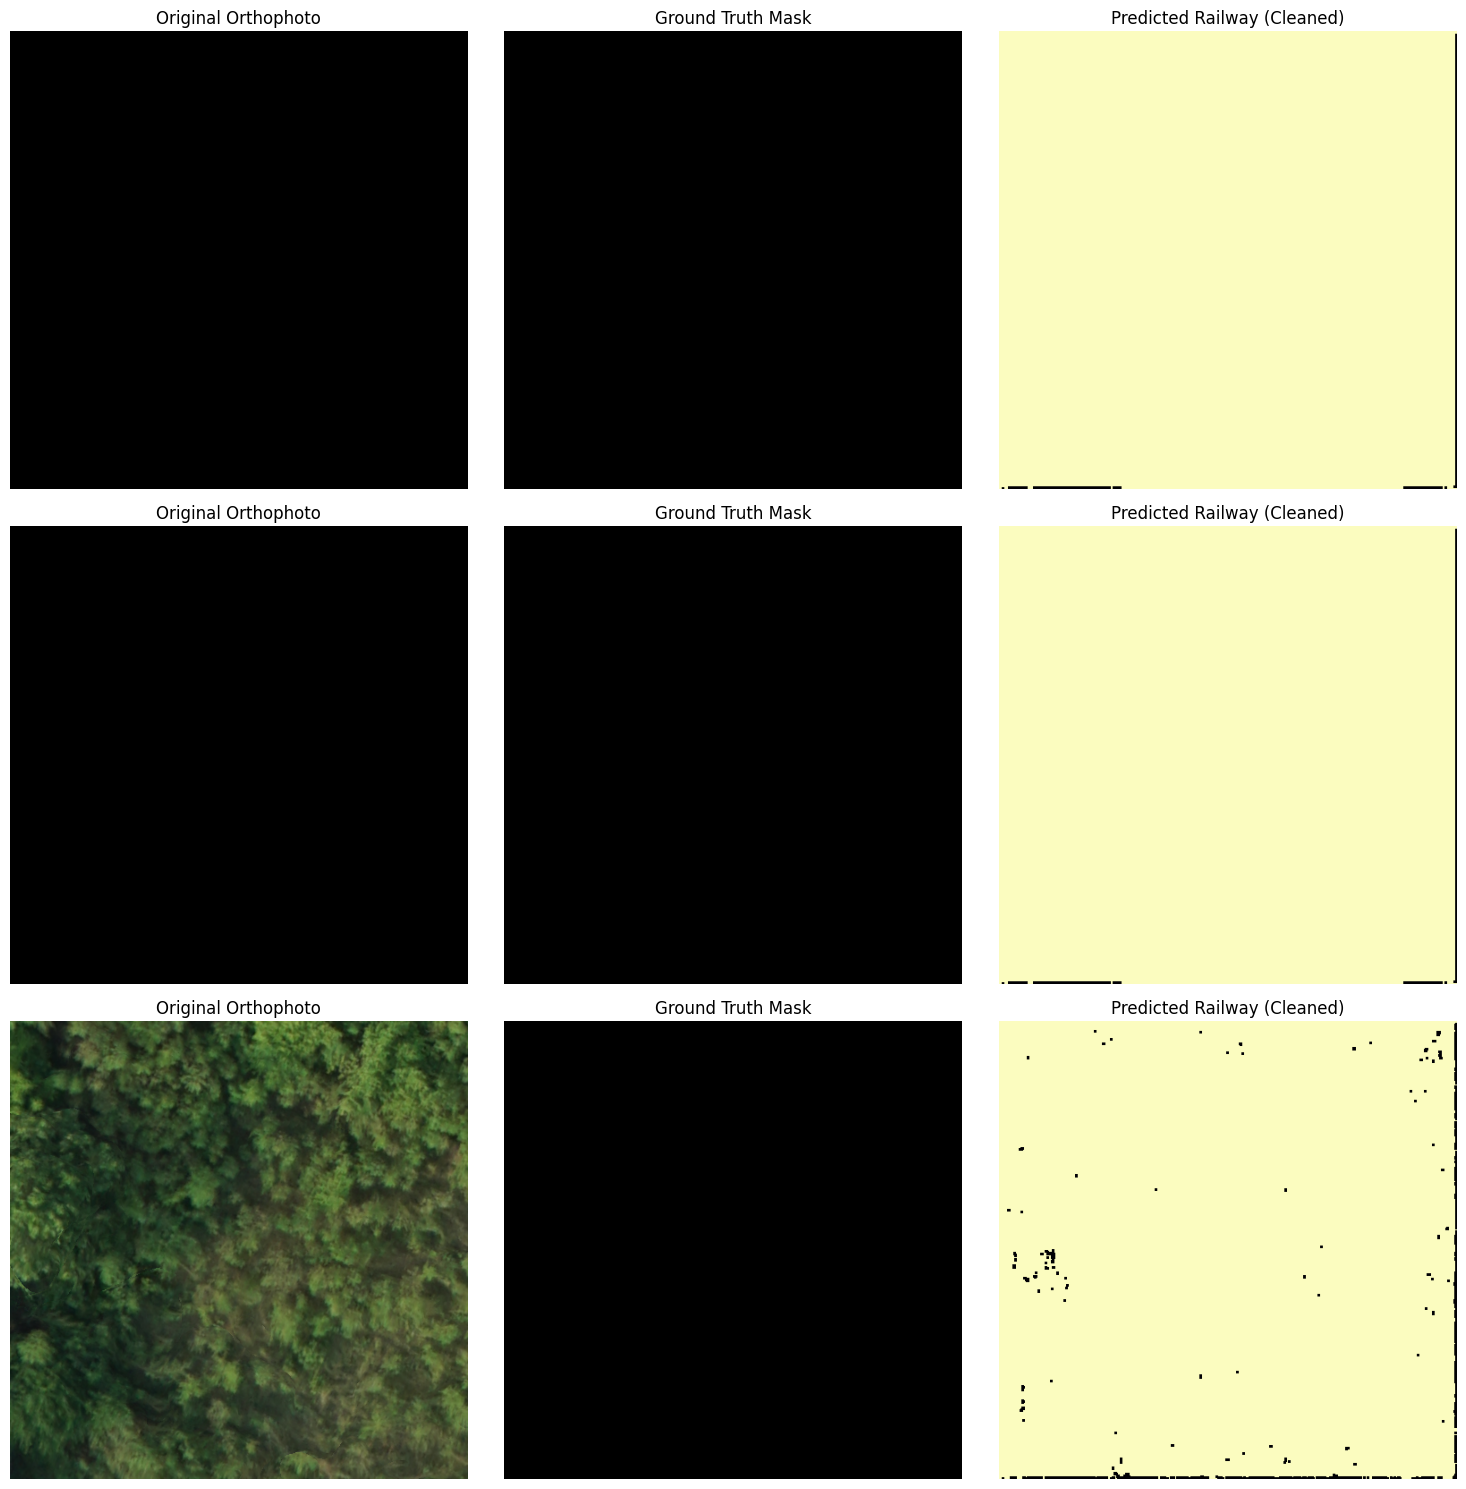

In [12]:
import torch.nn.functional as F
from skimage.morphology import skeletonize, remove_small_objects, closing, square

# 1. Sliding Window Inference
# Since the image is large, we predict in chunks and stitch
def predict_full_image(model, image_path, device, tile_size=512, overlap=128):
    model.eval()
    
    with rasterio.open(image_path) as src:
        # Read full image (or use windowed reading if huge - assuming it fits in RAM for now)
        full_img = src.read([1, 2, 3]).transpose(1, 2, 0) # HWC
        h, w, _ = full_img.shape
        
    # Container for prediction
    # We use a simple counter to handle overlap averaging
    # (For simplicity here, we'll just overwrite or use non-overlapping if easier, 
    # but smooth stitching is better. Let's do a simple tile-by-tile for speed/readability)
    
    # Actually, for "slide-by-slide" presentation quality, let's just pick a few Validation Patches from our dataset!
    # Predicting the ENTIRE orthophoto might take too long for a quick demo cell.
    # Let's visualize the Validation Set predictions which is perfect for PPTs.
    pass

# We'll create a visualization specific to the validation set we just trained on.
def visualize_results(model, dataset, device, num_samples=3):
    model.eval()
    
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img_tensor, mask_tensor = dataset[idx]
        
        # Inference
        input_tensor = img_tensor.unsqueeze(0).to(device) # Batch dim
        with torch.no_grad():
            logits = model(input_tensor)
            pred_prob = torch.sigmoid(logits)
            pred_mask = (pred_prob > 0.5).float().cpu().numpy()[0, 0]
            
        # Ground Truth
        gt_mask = mask_tensor.cpu().numpy()[0]
        
        # Original Image (Un-normalize for display)
        # Mean/Std from Albumentations
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * std + mean) # Denormalize
        img_np = np.clip(img_np, 0, 1)
        
        # --- Post Processing ---
        # 1. Morphological Closing (Connect gaps)
        cleaned_mask = closing(pred_mask.astype(int), square(3))
        
        # 2. Remove small noise
        cleaned_mask = remove_small_objects(cleaned_mask.astype(bool), min_size=50)
        
        # 3. Skeletonize (Optional - gets the centerline)
        # skeleton = skeletonize(cleaned_mask)
        
        # Visualization
        ax = axs[i] if num_samples > 1 else axs
        
        # 1. Original
        ax[0].imshow(img_np)
        ax[0].set_title("Original Orthophoto")
        ax[0].axis('off')
        
        # 2. Ground Truth (Green) vs Prediction (Red)
        # Overlay method
        overlay = img_np.copy()
        # GT in Green channel
        overlay[gt_mask == 1] = [0, 1, 0] 
        # Pred in Red channel (with transparency where it overlaps or distinct)
        # Let's just show Prediction purely for clarity in the second pane?
        # User requested: Original | GT | Prediction
        
        ax[1].imshow(gt_mask, cmap='gray')
        ax[1].set_title("Ground Truth Mask")
        ax[1].axis('off')
        
        # 3. Prediction (Post-Processed)
        ax[2].imshow(cleaned_mask, cmap='magma')
        ax[2].set_title("Predicted Railway (Cleaned)")
        ax[2].axis('off')
        
    plt.tight_layout()
    plt.savefig("railway_results_ppt.png", dpi=300)
    print("Saved visualization to railway_results_ppt.png")
    plt.show()

# Run Visualization on Val Set
visualize_results(model, val_dataset, DEVICE, num_samples=3)


In [ ]:
import torch.nn.functional as F
from skimage.morphology import remove_small_objects, closing, square
from rasterio.windows import Window
from tqdm import tqdm
import gc

TEST_IMAGE_PATH = "../data/live_demo_2/DIWANA_BARNALA_40082_ORTHO/DIWANA_BARNALA_40082_ORTHO.tif"
OUTPUT_PRED_PATH = "prediction_anaitpura_railway.tif" # Saving as TIF directly to support huge files

def predict_large_image_safe(model, image_path, output_path, device, tile_size=512):
    """
    Runs inference on a large GeoTIFF using strictly windowed reading/writing to avoid RAM spikes.
    """
    model.eval()
    
    # Pre-calculate transforms (Normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    with rasterio.open(image_path) as src:
        # Get dimensions
        h, w = src.height, src.width
        profile = src.profile.copy()
        
        # Prepare output profile (Single band, uint8)
        profile.update({
            'count': 1,
            'dtype': 'uint8',
            'driver': 'GTiff',
            'compress': 'lzw' # Compress to save disk space
        })
        
        # Create Tiled Calculation Steps
        steps_y = range(0, h, tile_size)
        steps_x = range(0, w, tile_size)
        total_steps = len(steps_y) * len(steps_x)
        
        print(f"Processing {w}x{h} image in {tile_size}x{tile_size} chunks...")
        
        # Open output file for writing
        with rasterio.open(output_path, 'w', **profile) as dst:
            
            pbar = tqdm(total=total_steps, desc="Inference")
            
            for y in steps_y:
                for x in steps_x:
                    # Define Window
                    # We read exactly tile_size, handling boundaries automatically by window sizing
                    # But for UNet, we need fixed size input (512x512). 
                    # If window is smaller (edge), we pad.
                    
                    window = Window(x, y, tile_size, tile_size)
                    
                    # Read only this specific window from disk
                    # 'boundless=True' automatically pads if we go off edge!
                    img_window = src.read([1, 2, 3], window=window, boundless=True, fill_value=0)
                    
                    # CHW -> HWC for processing
                    img_window = np.transpose(img_window, (1, 2, 0))
                    
                    # Normalize
                    img_window = img_window.astype(np.float32) / 255.0
                    img_window = (img_window - mean) / std
                    
                    # To Tensor
                    tensor = torch.from_numpy(img_window).permute(2, 0, 1).float().unsqueeze(0).to(device)
                    
                    # Inference
                    with torch.no_grad():
                        logits = model(tensor)
                        prob = torch.sigmoid(logits) # (1, 1, 512, 512)
                        
                    # To mask
                    pred = (prob > 0.5).float().cpu().numpy()[0, 0] # (512, 512)
                    pred = pred.astype(np.uint8)
                    
                    # We need to write back exactly the size of the valid window (not the padded part)
                    # Calculate actual valid width/height for this block
                    valid_w = min(tile_size, w - x)
                    valid_h = min(tile_size, h - y)
                    
                    # Crop valid part
                    pred_valid = pred[:valid_h, :valid_w]
                    
                    # Write to disk
                    dst.write(pred_valid, 1, window=Window(x, y, valid_w, valid_h))
                    
                    pbar.update(1)
                    
                    # Garbage collection explicitly to be safe
                    del tensor, logits, prob, pred
            
            pbar.close()
            
    # Force GC
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Prediction saved to {output_path}")

# Run Safe Prediction
predict_large_image_safe(model, TEST_IMAGE_PATH, OUTPUT_PRED_PATH, DEVICE)

# Visualization Cell (Safe Reading)
# We find a random spot to check, or center (safer than reading whole mask to find "True" pixels)
print("Generating Preview...")

# We'll just visualize the center of the image
with rasterio.open(TEST_IMAGE_PATH) as src:
    cx, cy = src.width // 2, src.height // 2
    window_size = 1000
    w_off = max(0, cx - window_size//2)
    h_off = max(0, cy - window_size//2)
    
    viz_window = Window(w_off, h_off, window_size, window_size)
    
    img_crop = src.read([1,2,3], window=viz_window)
    img_crop = np.transpose(img_crop, (1, 2, 0))

with rasterio.open(OUTPUT_PRED_PATH) as msk:
    mask_crop = msk.read(1, window=viz_window)

# Simple plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_crop)
plt.title("Center Crop (Image)")
plt

Processing 5231x3919 image in 512x512 chunks...


/home/anushtup-ghosh/Documents/Projects/natgeo/venv/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


RasterioIOError: prediction_anaitpura_railway.tif: Currently, PHOTOMETRIC=YCBCR requires COMPRESS=JPEG

In [13]:
import torch
import segmentation_models_pytorch as smp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "../models/railway_unet.pth"

print(f"Loading model architecture on {DEVICE}...")

# 1. Re-define the exact same architecture
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # No need to download pretrained weights, we are loading our own
    in_channels=3,
    classes=1,
    activation=None
)

# 2. Load the state dict
# map_location ensures it loads to the right device even if trained on a different specific GPU
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()

print("Model weights loaded successfully. Ready for inference.")

Loading model architecture on cuda...
Model weights loaded successfully. Ready for inference.
